## Text Highlight plot: SLALOM vs Yelp HAT

In [1]:
import os
os.chdir("..")

In [2]:
from transformers import AutoTokenizer

run_long = "yelp_bert_6_pretrained_r7"
run = "bert"
if "gpt" in run:
    tokenizer = AutoTokenizer.from_pretrained('distilgpt2', use_fast=True)
else:
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)

In [3]:
## Load tokens
path = "/mnt/ssd3/tobias/AttentionMatricesRaw/models"

def load_tokens(file_name, stop_sep=False):
    mylist = []
    with open(file_name, 'r') as file:
        for line in file:
            if not stop_sep or ((line.strip("\n") != "[PAD]") and not ('<|endoftext|>' in line)):
                mylist.append(line.strip("\n"))
    return mylist

def convert_token_list_to_inputs(inp_list, tok):
    """ TODO: make more solid implementation. """
    return tok.convert_tokens_to_ids(inp_list)

In [66]:

from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
def visualize_attention(att_mat, decoded_tokens, start_pos_y, max_len=50, vmax=2, vmin=None):
    '''
    s_pos: from which token the attention should be visualized (usually the CLS token)
    start_pos_y: for visalizing multiple rows
    max_len: how many tokens should be visualized
    '''
    # average over all heads
    #att_mat = att_mat.sum(axis=1)/att_mat.shape[1]
    #cls_atts = np.flip(att_mat[:,s_pos], axis=0)
    cls_atts = att_mat[:max_len]


    fig, ax = plt.subplots(figsize=(7, 3))
    rend = fig.canvas.get_renderer()
    pos_x = 15
    max_x = 500
    pos_y = start_pos_y
    whitespace = 10
    norm = Normalize(vmin=-vmax if vmin is None else vmin, vmax=vmax)
    #cmap = plt.cm.YlOrRd
    cmap = plt.cm.PiYG
    plt.xlim([0, max_x+50])
    for token, att in zip(decoded_tokens, cls_atts):
        bb = dict(boxstyle="square, pad=0.2", fc=cmap(norm(att), alpha=0.7))
        text = plt.text(pos_x, pos_y, token.replace("##", "").replace("Ġ", ""), color='black', bbox=bb, fontsize=12)
        pos_x += text.get_window_extent(renderer=rend).width + whitespace

        if pos_x > max_x:
            pos_x = 15
            pos_y -= 25
    plt.ylim([pos_y-40, start_pos_y+15])
    #cax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Adjust these values as needed
    #cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
    #cb.set_label('Attention Score', fontsize=10)
    #cb.ax.tick_params(axis='both', labelsize=10)


    ax.set_facecolor('none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    plt.show()
    return fig, ax

In [6]:
import json
data = open("datasets/slalom_hat_scores_17.json")
data = json.load(data)
tokens = data["tokens"]
hat = data["hat"]

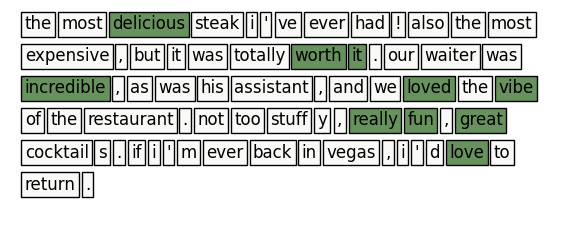

In [7]:
f, ax = visualize_attention(hat, tokens,start_pos_y=500, max_len=200, vmax=1)

In [8]:
f.savefig(f"figures/E_slalom_vs_hat_hat_true.pdf")

## Visualize absolute LIME/SHAP scores

In [9]:
import torch
#run = metrics_config["model"][1]
s_dict = torch.load(f"{path}/{run_long}.pt")

/tmp/ipykernel_2404536/1550685399.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_dict = torch.load(f"{path}/{run_long}.pt")


In [11]:
from slalom_explanations.transformer_models import Bert
model_obj = Bert(n_layers=6, n_heads=12, pretrained=True)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True, padding=512)
use_cls = True
model_obj.model.load_state_dict(s_dict)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [61]:
from slalom_explanations.attribution_methods import LIMEExplanation, ShapleyValues, LRPExplanation, SLALOMLocalExplanantions
myshap = ShapleyValues(model_obj.model, tokenizer, device="cuda:3", method="kernel", num_samples=5000)
mylime = LIMEExplanation(model_obj.model, tokenizer, device="cuda:3", n_samples=5000)
mylrp = LRPExplanation(model_obj.model, device="cuda:3")
myslalomeff = SLALOMLocalExplanantions(model_obj.model, device="cuda:3", sgd_lr= 1e-2, sgd_epochs= 50, modes = ["lin"], n_samples = 5000, seq_len= 2)
myslalomfidel = SLALOMLocalExplanantions(model_obj.model, device="cuda:3", sampling_strategy="deletion", n_samples = 5000, fit_sgd=False,  modes= ["lin", "value"])

cuda:3


In [19]:
input_tokens = tokenizer.convert_tokens_to_ids(tokens)

In [20]:
res_shap = myshap.get_signed_importance_for_tokens(input_tokens)

In [21]:
res_shap

array([ 0.70162929, -0.17792769,  1.15288378,  0.16901389,  0.12626798,
        0.013866  ,  0.0686568 ,  0.07951618, -0.07428903,  0.11549888,
        0.        ,  0.0430906 , -0.05414632, -0.11357751,  0.08726966,
       -0.10340574,  0.02943227, -0.16299748,  0.14915683,  0.34277661,
        0.12230997,  0.10446324,  0.08127614,  0.03554189,  0.07908018,
        0.62727219,  0.09028921,  0.        , -0.05751775,  0.06560657,
        0.11146199,  0.11595859,  0.19737207,  0.1521393 ,  0.46093271,
        0.16514561,  0.20253542,  0.06673827,  0.09526365,  0.1742118 ,
        0.05444091, -0.12198331, -0.0536318 ,  0.02877385,  0.05193508,
        0.07517762,  0.10087502,  0.21761338,  0.14865245,  0.29119219,
        0.25976832, -0.07093229,  0.        , -0.1964138 ,  0.07150156,
        0.00333391, -0.0311267 ,  0.02624788, -0.018715  ,  0.04410582,
        0.17477638,  0.09720909,  0.03717437,  0.        ,  0.02580067,
        0.11172689,  0.05815014, -0.02636889,  0.1133816 ])

In [ ]:
#f.savefig(f"figures/E_slalom_vs_hat_slalom.pdf")

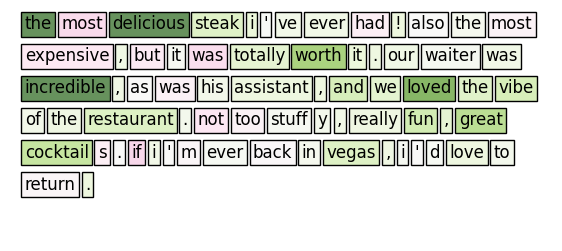

In [25]:
import numpy as np
f, ax = visualize_attention(res_shap, tokens,start_pos_y=500, max_len=200, vmax=.6)

In [26]:
f.savefig(f"figures/E_slalom_vs_hat_shap.pdf")

In [27]:
res_lime = mylime.get_signed_importance_for_tokens(input_tokens)

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [28]:
res_lime

array([ 1.64347202e-03,  3.43488221e-03,  9.30590433e-03,  2.69165553e-03,
        1.84644419e-03, -3.49342053e-07, -6.84537821e-04,  1.68596545e-03,
        8.74610283e-04,  4.29031443e-03,  3.83643595e-03,  1.64347202e-03,
        3.43488221e-03, -8.67765112e-03,  1.21862398e-03,  4.57512686e-04,
        6.12795551e-04, -6.02169326e-03,  6.81676411e-03,  8.53431705e-03,
        6.12795551e-04, -3.72343460e-03,  2.00579709e-03, -2.02141562e-03,
       -6.02169326e-03,  1.01639462e-02,  1.21862398e-03, -1.18813784e-03,
       -6.02169326e-03,  6.13440757e-05,  1.52851745e-03,  1.21862398e-03,
        4.69848422e-03,  6.54986038e-06,  7.78898309e-03,  1.64347202e-03,
        1.69003302e-03,  1.10214491e-03,  1.64347202e-03,  1.05048538e-04,
       -3.72343460e-03, -7.85541588e-03,  1.16794950e-03,  9.64256633e-05,
        1.19779147e-03,  1.21862398e-03,  3.83565770e-03,  5.16376669e-03,
        1.21862398e-03,  4.67273432e-03,  4.11277918e-03, -3.08129684e-03,
       -3.72343460e-03, -

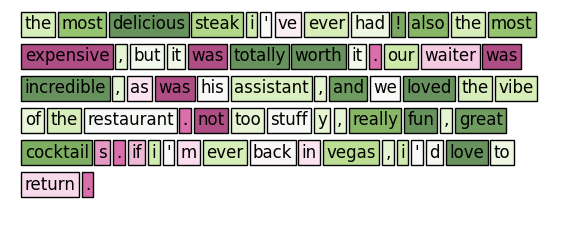

In [30]:
f, ax = visualize_attention(res_lime, tokens,start_pos_y=500, max_len=200, vmax=0.005)

In [31]:
f.savefig(f"figures/E_slalom_vs_hat_lime.pdf")

In [32]:
res_lrp = mylrp.get_signed_importance_for_tokens(input_tokens)

tensor([6.8132], device='cuda:3', grad_fn=<SubBackward0>) tensor([6.8132], device='cuda:3')


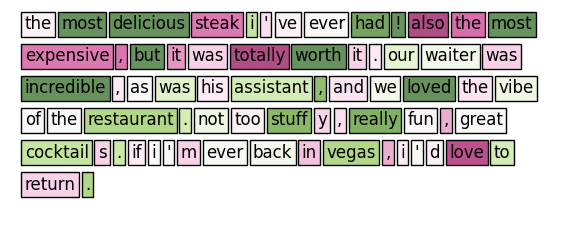

In [35]:
f, ax = visualize_attention(res_lrp, tokens,start_pos_y=500, max_len=200, vmax=0.6)

In [36]:
f.savefig(f"figures/E_slalom_vs_hat_lrp.pdf")

In [37]:
res_slalom = myslalomeff.get_signed_importance_for_tokens(input_tokens)

Pad-Token-ID: 0
19.728896671649686
19.579706740671163
19.430802978252135
19.28154000408378
19.131472773672407
18.98007113812545
18.826727453515254
18.67079488590283
18.511634231772025
18.34866970937554
18.181439319596507
18.009636904792554
17.833134305098103
17.65198998600941
17.46643392552175
17.27684295354133
17.083709297514737
16.887609179565736
16.689185819381457
16.4891303102969
16.28815917051355
16.08697666423327
15.886235166202162
15.686500336761627
15.488231418019073
15.29178273144723
15.097419786274864
14.905337440233417
14.715669896625847
14.528503812163349
14.343886887465251
14.161839632618369
13.982369090249325
13.805473065957724
13.63115197015991
13.459410855463872
13.290261775985629
13.123723852581069
12.95982194918492
12.798583558515297
12.640035196708432
12.48420094784488
12.331098331256868
12.180736709126371
12.033118223925705
11.88823542744872
11.74607401028128
11.606611874372296
11.469822587922494
11.335673576476704


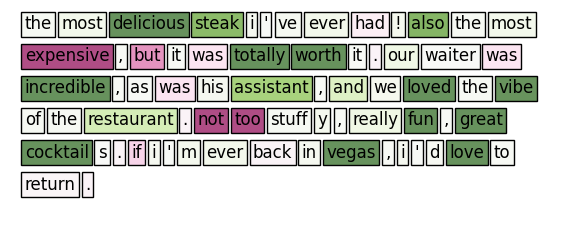

In [43]:
f, ax = visualize_attention(res_slalom.flatten(), tokens,start_pos_y=500, max_len=200, vmax=1.0)

In [44]:
f.savefig(f"figures/E_slalom_vs_hat_slalomeff.pdf")

In [62]:
res_slalom = myslalomfidel.get_signed_importance_for_tokens(input_tokens)

MSE: 0.0007554544135928154
     message: Both `ftol` and `xtol` termination conditions are satisfied.
     success: True
      status: 4
         fun: [ 3.419e-01 -2.336e+00 ... -4.784e-01 -2.174e-03]
           x: [ 8.426e-01  2.598e-01 ...  8.793e-01  4.900e+01]
        cost: 5730.093682795284
         jac: [[-8.470e+00 -8.186e-01 ...  2.239e+00  0.000e+00]
               [-8.489e+00 -8.755e-01 ...  2.220e+00  0.000e+00]
               ...
               [-8.437e+00 -7.203e-01 ...  2.271e+00  0.000e+00]
               [ 1.000e+05  1.000e+05 ...  1.000e+05 -1.000e+05]]
        grad: [ 1.671e+01  2.987e+02 ...  3.493e+01  2.174e+02]
  optimality: 262.29333215544534
 active_mask: [ 0  0 ...  0 -1]
        nfev: 9
        njev: 9
MSE: 0.0007567920256406069


In [63]:
res_slalom.shape

(2, 69)

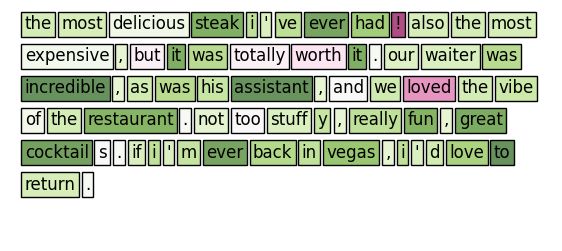

In [70]:
f, ax = visualize_attention(res_slalom[0,:].flatten(), tokens,start_pos_y=500, max_len=200, vmax=10, vmin=0)

In [71]:
f.savefig(f"figures/E_slalom_vs_hat_slalomfidel.pdf")